<a href="https://colab.research.google.com/github/luccaamvs/ADOCanvas/blob/main/An%C3%A1lise_de_Sentimentos_ML_Definitivo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Imports



In [1]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import string
from bs4 import BeautifulSoup

Lendo o Arquivo .CSV

In [9]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('sentiment_tweets3.csv', encoding='utf-8')
df.rename(columns={'message to examine': 'Text', 'label (depression result)': 'Label'}, inplace=True)

Saving sentiment_tweets3.csv to sentiment_tweets3.csv


Tratamento de Texto e URL/Limpeza

In [26]:
# Converte todo o texto pra lowercase
df['Text'] = df['Text'].str.lower()

# Função para sanitizar o conteúdo textual
def limpar_texto(texto):
    texto = re.sub(r"http\S+", "", texto)  # elimina URLs
    texto = re.sub(r"@\w+", "", texto)     # elimina menções
    texto = re.sub(r"[^a-zA-Z\s]", "", texto)  # elimina caracteres não alfabéticos
    return texto

# Conjunto de sinais de pontuação a remover
pontuacoes = string.punctuation

# Função para eliminar pontuação
def excluir_pontuacao(frase):
    return frase.translate(str.maketrans('', '', pontuacoes))

# Aplica a função de remoção de pontuação
df['Text'] = df['Text'].apply(excluir_pontuacao)

# Aplica a função de limpeza geral
df['texto_limpo'] = df['Text'].apply(limpar_texto)

# Função para retirar marcações HTML
def extrair_texto_sem_tags(html):
    conteudo = BeautifulSoup(html, 'html.parser')
    return conteudo.get_text()

# Remove URLs e marcações HTML
df['Text'] = df['Text'].apply(extrair_texto_sem_tags)


df.head()

,Index,Text,Label,texto_limpo,texto_lematizado
0,106,real good moment missssssssss much,0,real good moment missssssssss much,real good moment missssssssss much
1,217,reading manga httpplurkcompmzp1e,0,reading manga,read manga httpplurkcompmzp1e
2,220,comeagainjen httptwitpiccom2y2lx httpwwwyoutub...,0,comeagainjen,comeagainjen httptwitpiccom2y2lx httpwwwyoutub...
3,288,lapcat need send em accountant tomorrow oddly ...,0,lapcat need send em accountant tomorrow oddly ...,lapcat need send em accountant tomorrow oddly ...
4,540,add myspace myspacecomlookthunder,0,add myspace myspacecomlookthunder,add myspace myspacecomlookthunder



Chatwords -> Definir um dicionario de palavras e termos usados na Web para serem detectadas pelo modelo.

In [11]:
chat_words = {
    "IDK": "I Don't Know",
    "IDC": "I Don't Care",
    "IMO": "In My Opinion",
    "IMHO": "In My Humble Opinion",
    "IIRC": "If I Recall Correctly",
    "FTW": "For The Win",
    "SMH": "Shaking My Head",
    "TBH": "To Be Honest",
    "TMI": "Too Much Information",
    "YOLO": "You Only Live Once",
    "FOMO": "Fear Of Missing Out",
    "BRUH": "Bro / Dude (expression of disbelief)",
    "DM": "Direct Message",
    "PM": "Private Message",
    "NSFW": "Not Safe For Work",
    "IRL": "In Real Life",
    "RN": "Right Now",
    "IDC": "I Don’t Care",
    "OMW": "On My Way",
    "ICYMI": "In Case You Missed It",
    "TL;DR": "Too Long; Didn't Read",
    "IMO": "In My Opinion",
    "LMK": "Let Me Know",
    "NVM": "Never Mind",
    "OTP": "One True Pairing",
    "BTAIM": "Be That As It May",
    "IDGAF": "I Don't Give A F***",
    "GTG": "Got To Go",
    "TTYS": "Talk To You Soon",
    "YMMV": "Your Mileage May Vary",
    "GGWP": "Good Game, Well Played",
    "GGEZ": "Good Game, Easy Win",
    "SMH": "Shaking My Head",
    "HF": "Have Fun",
    "GL": "Good Luck",
    "GLHF": "Good Luck, Have Fun",
    "NGL": "Not Gonna Lie",
    "LPT": "Life Pro Tip",
    "YOLO": "You Only Live Once",
    "HBD": "Happy Birthday",
    "IYKYK": "If You Know, You Know",
    "ILYSM": "I Love You So Much",
    "IDC": "I Don't Care",
    "IDC": "I Don't Care",
    "IDRC": "I Don't Really Care",
    "TBF": "To Be Fair",
    "GRWM": "Get Ready With Me",
    "RN": "Right Now",
    "FR": "For Real",
    "FRFR": "For Real For Real",
    "SUS": "Suspicious / Suspect",
    "CAP": "Lie / Not True",
    "NO CAP": "No Lie / For Real"
}

# Troca chat words por sua real definição
def replace_chat_words(text):
    words = text.split()
    for i, word in enumerate(words):
        if word.lower() in chat_words:
            words[i] = chat_words[word.lower()]
    return ' '.join(words)

df['Text'] = df['Text'].apply(replace_chat_words)
df.head()

,Index,Text,Label,texto_limpo
0,106,just had a real good moment i missssssssss him...,0,just had a real good moment i missssssssss him...
1,217,is reading manga httpplurkcompmzp1e,0,is reading manga
2,220,comeagainjen httptwitpiccom2y2lx httpwwwyoutub...,0,comeagainjen
3,288,lapcat need to send em to my accountant tomorr...,0,lapcat need to send em to my accountant tomorr...
4,540,add me on myspace myspacecomlookthunder,0,add me on myspace myspacecomlookthunder


Retirada de Stopwords (palavras irrelevantes como "the, on, at")

In [13]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords


def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))  # Cria um conjunto com as stopwords
    words = text.split()  # Divide o texto em palavras (tokens)
    filtered_words = [word for word in words if word.lower() not in stop_words]  # Remove as que estão na lista
    return " ".join(filtered_words)  # Junta novamente o texto limpo

df['Text'] = df['Text'].apply(remove_stopwords)
df.head(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Index,Text,Label,texto_limpo
0,106,real good moment missssssssss much,0,just had a real good moment i missssssssss him...
1,217,reading manga httpplurkcompmzp1e,0,is reading manga
2,220,comeagainjen httptwitpiccom2y2lx httpwwwyoutub...,0,comeagainjen
3,288,lapcat need send em accountant tomorrow oddly ...,0,lapcat need to send em to my accountant tomorr...
4,540,add myspace myspacecomlookthunder,0,add me on myspace myspacecomlookthunder
5,624,sleepy good times tonight though,0,so sleepy good times tonight though
6,701,silkcharm nbn someone already said fiber home ...,0,silkcharm re nbn as someone already said does ...
7,808,23 24ï¿½c possible today nice,0,or c possible today nice
8,1193,nite twitterville workout ciao,0,nite twitterville workout in the am ciao
9,1324,dananner night darlin sweet dreams,0,dananner night darlin sweet dreams to you


Reduzindo estruturas das palavras

In [15]:
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('wordnet')
nltk.download('omw-1.4')

# lematizador
lemmatizer = WordNetLemmatizer()

# Lematização nos textos
df['texto_lematizado'] = df['Text'].apply(
    lambda frase: ' '.join([lemmatizer.lemmatize(termo, pos='v') for termo in frase.split()])
)

df.head(10)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,Index,Text,Label,texto_limpo,texto_lematizado
0,106,real good moment missssssssss much,0,just had a real good moment i missssssssss him...,real good moment missssssssss much
1,217,reading manga httpplurkcompmzp1e,0,is reading manga,read manga httpplurkcompmzp1e
2,220,comeagainjen httptwitpiccom2y2lx httpwwwyoutub...,0,comeagainjen,comeagainjen httptwitpiccom2y2lx httpwwwyoutub...
3,288,lapcat need send em accountant tomorrow oddly ...,0,lapcat need to send em to my accountant tomorr...,lapcat need send em accountant tomorrow oddly ...
4,540,add myspace myspacecomlookthunder,0,add me on myspace myspacecomlookthunder,add myspace myspacecomlookthunder
5,624,sleepy good times tonight though,0,so sleepy good times tonight though,sleepy good time tonight though
6,701,silkcharm nbn someone already said fiber home ...,0,silkcharm re nbn as someone already said does ...,silkcharm nbn someone already say fiber home m...
7,808,23 24ï¿½c possible today nice,0,or c possible today nice,23 24ï¿½c possible today nice
8,1193,nite twitterville workout ciao,0,nite twitterville workout in the am ciao,nite twitterville workout ciao
9,1324,dananner night darlin sweet dreams,0,dananner night darlin sweet dreams to you,dananner night darlin sweet dream


Train Test Split

In [16]:
# Separa os dados em treino e teste
X = df['Text']
y = df['Label']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #20% dos dados vão para teste, 80% para treino.

In [17]:
# Prepara tokenização e padding

tokenizer = Tokenizer(oov_token = 'nothing') # é usado para converter palavras em número e define um token especial para palavras desconhecidas.


# Cria um vocabulário com base em todas as palavras presentes nos textos de treino e teste.

tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

tokenizer.document_count

10314

In [18]:
# Sequencias de treino (Transforma cada frase em uma lista de números, usando o vocabulário aprendido.)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

maxlen = max(len(tokens) for tokens in X_train_sequences) # Determinamos o comprimento máximo das frases no conjunto de treino.
print("Tamanho Máximo:", maxlen)

Tamanho Máximo: 75


In [19]:
# Preenchimento no X_train e X_test sequences

X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')

# Print das sequencias
print("Preenchimento X de Treino:")
print(X_train_padded)
print("Preenchimento X de Teste:")
print(X_test_padded)

Preenchimento X de Treino:
[[ 6407    22   701 ...     0     0     0]
 [   15  4133  1222 ...     0     0     0]
 [ 6408  6409     3 ...     0     0     0]
 ...
 [20216   944     0 ...     0     0     0]
 [  400  1869  5583 ...     0     0     0]
 [  418    14  1109 ...     0     0     0]]
Preenchimento X de Teste:
[[20217   351   129 ...     0     0     0]
 [20218   712   193 ...     0     0     0]
 [20219    84    98 ...     0     0     0]
 ...
 [23637  5023 23638 ...     0     0     0]
 [23640   632   143 ...     0     0     0]
 [23641   639   824 ...     0     0     0]]


Embedding e Input Size

In [20]:
# Uma camada Embedding transforma índices inteiros (tokens) em vetores de números reais (embeddings) .
input_Size = np.max(X_train_padded) + 1
input_Size

np.int32(20217)

Criação do Modelo

In [22]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Tipo do modelo
model = Sequential()

# LSTM (Long Short-Term Memory) é uma RNN avançada capaz de capturar dependências de longo prazo, melhor para dados sequenciais
model.add(LSTM(128, input_shape=(75,1), return_sequences=True))

# Dropout desliga aleatoriamente 50% dos neurônios durante o treino, ajudando a evitar overfitting.
model.add(Dropout(0.5))

# Segunda camada LSTM continua processando a sequência que vem da anterior
model.add(LSTM(128))

# Outro Dropout para reduzir o risco de overfitting
model.add(Dropout(0.5))

# Camada densa intermediária, serve como uma camada combinadora, integrando os recursos aprendidos pela LSTM.
model.add(Dense(64, activation='relu'))

# Camada de saída para classificação binária.
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Compilando Modelo (Se der errado, usar Adam)

In [23]:
from tensorflow.keras.optimizers import RMSprop

# Compila o modelo usando RMSprop como otimizador
model.compile(
    optimizer=RMSprop(learning_rate=0.001),  # você pode ajustar a taxa de aprendizado se quiser
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Exibe o resumo do modelo
model.summary()

# Compila o modelo usando Adam como otimizador
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 75, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,465 (806.50 KB)

 Trainable params: 206,465 (806.50 KB)

 Non-trainable params: 0 (0.00 B)

Treinamento do Modelo

In [24]:
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_data=(X_test_padded, y_test))

Epoch 1/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 72s 263ms/step - accuracy: 0.7727 - loss: 0.5599 - val_accuracy: 0.7824 - val_loss: 0.5282
Epoch 2/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 79s 251ms/step - accuracy: 0.7716 - loss: 0.5449 - val_accuracy: 0.7824 - val_loss: 0.5316
Epoch 3/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 79s 240ms/step - accuracy: 0.7811 - loss: 0.5289 - val_accuracy: 0.7824 - val_loss: 0.5039
Epoch 4/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 83s 243ms/step - accuracy: 0.7731 - loss: 0.5407 - val_accuracy: 0.7824 - val_loss: 0.5267
Epoch 5/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 81s 239ms/step - accuracy: 0.7813 - loss: 0.5304 - val_accuracy: 0.7824 - val_loss: 0.5252


Mostrando gráficos finais (Acurácia)

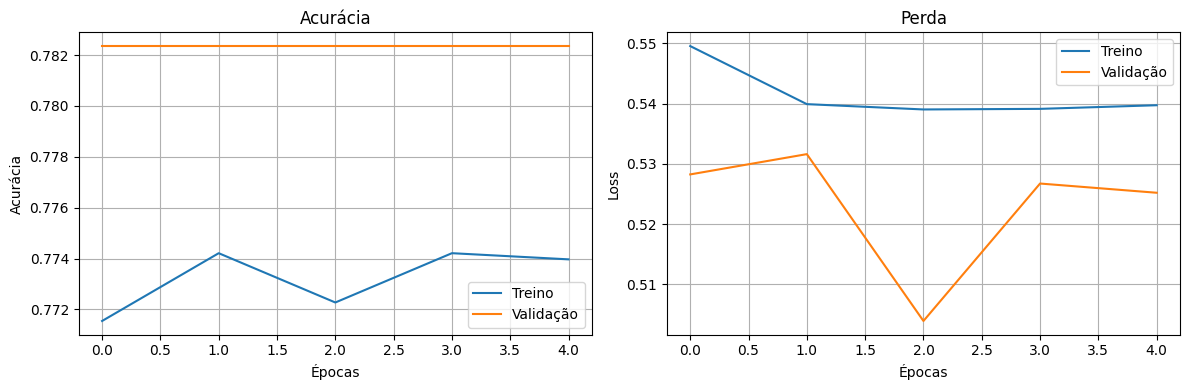

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Acurácia
axs[0].plot(history.history['accuracy'], label='Treino')
axs[0].plot(history.history['val_accuracy'], label='Validação')
axs[0].set_title('Acurácia')
axs[0].set_xlabel('Épocas')
axs[0].set_ylabel('Acurácia')
axs[0].legend()
axs[0].grid(True)

# Perda
axs[1].plot(history.history['loss'], label='Treino')
axs[1].plot(history.history['val_loss'], label='Validação')
axs[1].set_title('Perda')
axs[1].set_xlabel('Épocas')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()